In [1]:

!pip install transformers
from transformers import RobertaTokenizer


     |████████████████████████████████| 778kB 5.4MB/s 
     |████████████████████████████████| 890kB 31.3MB/s 
     |████████████████████████████████| 1.1MB 50.2MB/s 
     |████████████████████████████████| 3.0MB 55.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=e9973bd3fa6b19101eebac5a4c9f47f27e3f096f6d3ef3a608798c2ecd3db52a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
from google.colab import drive

# set environment as googledrive to folder "resource"
data_path =  "/resource/"

try:
    drive.mount('/content/drive')
    data_path = "/content/drive/My Drive/resource/"

except:
    print("You are not working in Colab at the moment :(")

In [3]:
import pandas as pd
import tensorflow as tf
import torch

device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    device = torch.device("cuda")
    print('GPU:', torch.cuda.get_device_name(0))
else:
    raise SystemError('GPU device not found')

GPU: Tesla P100-PCIE-16GB


In [5]:
modelname=data_path+"nslmodel/"
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [6]:
import pandas as pd
# Recommended tensorflow version is <= 2.1.0, otherwise F1 score function breaks
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
from transformers import TFRobertaForSequenceClassification
from transformers import RobertaTokenizer
import os
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Load your Dataset
dataset_path = data_path+"new_train.csv"
#dataset_path = data_path+"1.csv"

train_tweets = pd.read_csv(dataset_path,sep="\t")
del train_tweets['index']
train_tweets['category'] = train_tweets['category']=="normal"
train_tweets['category'] = train_tweets['category'].astype('int')

print(train_tweets.groupby("category").size())
#test_tweets = pd.read_csv(data_path+'new_test.csv')

#test_tweets['label'] = 0
train_tweets=train_tweets.rename(columns={"category":'label', "text":'tweet'})
training_sentences, testing_sentences = train_test_split(train_tweets[['tweet', 'label']],
                                                         test_size=0.1)


#training_sentences, testing_sentences = train_test_split(testing_sentences[['tweet', 'label']], test_size=0.9)



roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# can be up to 512 for BERT
max_length = 100

# the recommended batches size for BERT are 32,64 ... however on this dataset we are overfitting quite fast
# and smaller batches work like a regularization.
# You might play with adding another dropout layer instead.

batch_size = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


category
0    58630
1    67343
dtype: int64


In [7]:
import logging
logging.basicConfig(level=logging.ERROR)
def convert_example_to_feature(review):
    # combine step for tokenization, WordPiece vector mapping and will
    # add also special tokens and truncate reviews longer than our max length
    return roberta_tokenizer.encode_plus(review,
                                 add_special_tokens=True,  # add [CLS], [SEP]
                                 max_length=max_length,  # max length of the text that can go to RoBERTa
                                 pad_to_max_length=True,  # add [PAD] tokens at the end of sentence
                                 return_attention_mask=True,  # add attention mask to not focus on pad tokens
                                 )

# map to the expected input to TFRobertaForSequenceClassification, see here
def map_example_to_dict(input_ids, attention_masks, label):
    return {
      "input_ids": input_ids,
      "attention_mask": attention_masks,
           }, label

def encode_examples(ds, limit=-1):
    # Prepare Input list
    input_ids_list = []
    attention_mask_list = []
    label_list = []

    if (limit > 0):
        ds = ds.take(limit)

    for review, label in tfds.as_numpy(ds):
        bert_input = convert_example_to_feature(review.decode())
        input_ids_list.append(bert_input['input_ids'])
        attention_mask_list.append(bert_input['attention_mask'])
        label_list.append([label])

    return tf.data.Dataset.from_tensor_slices((input_ids_list,
                                               attention_mask_list,
                                               label_list)).map(map_example_to_dict)

training_sentences_modified = tf.data.Dataset.from_tensor_slices((training_sentences['tweet'],
                                                                  training_sentences['label']))

testing_sentences_modified = tf.data.Dataset.from_tensor_slices((testing_sentences['tweet'],
                                                                 testing_sentences['label']))

ds_train_encoded = encode_examples(training_sentences_modified).shuffle(10000).batch(batch_size)
ds_test_encoded = encode_examples(testing_sentences_modified).batch(batch_size)



learning_rate = 7e-5
number_of_epochs = 3




In [8]:
class ModelMetrics(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.count_n = 1
      
    def on_epoch_end(self, batch, logs={}):
       
        os.mkdir(data_path + str(self.count_n))
        print(3)
        self.model.save_pretrained(data_path + str(self.count_n)) # this folder address should match with folder we created above
        print(4)
        y_val_pred = tf.nn.softmax(self.model.predict(ds_test_encoded))
        print(5)
        y_pred_argmax = tf.math.argmax(y_val_pred, axis=1)
        print(6)
        testing_copy = testing_sentences.copy()
        print(7)
        print( y_pred_argmax, len(y_pred_argmax))
        #testing_copy['predicted'] = y_pred_argmax
        print(8)
        #f1_s = f1_score(testing_sentences['label'], testing_copy['predicted'])
        print(9)
        #print('\n f1 score is :', f1_s)
        self.count_n += 1

In [9]:

metrics = ModelMetrics()

# model initialization
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)


loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])


In [10]:
number_of_epochs=1
model.fit(ds_train_encoded, epochs=number_of_epochs, validation_data=ds_test_encoded, callbacks=[metrics])

1772/1772 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.98743
4
5
6
7
tf.Tensor([[11187  5547]], shape=(1, 2), dtype=int64) 1
8
9
1772/1772 [==============================] - 1351s 762ms/step - loss: 0.0395 - accuracy: 0.9874 - val_loss: 0.0149 - val_accuracy: 0.9949


In [11]:
dataset_path = data_path+"new_test.csv"


test_tweets = pd.read_csv(dataset_path,sep="\t")
del test_tweets['index']
test_tweets['category'] = test_tweets['category']=="normal"
test_tweets['category'] = test_tweets['category'].astype('int')



print(test_tweets.groupby("category").size())



test_tweets=test_tweets.rename(columns={"category":'label', "text":'tweet'})


                                                   test_size=0.1)



testing_sentences_modified = tf.data.Dataset.from_tensor_slices((test_tweets['tweet'],
                                                                 test_tweets['label']))
xds_test_encoded = encode_examples(testing_sentences_modified).batch(batch_size)

category
0    12833
1     9710
dtype: int64


In [12]:
results2 = model.evaluate(xds_test_encoded, batch_size=128)
print("test loss, test acc:", results2)

353/353 [==============================] - 86s 244ms/step - loss: 0.9595 - accuracy: 0.7451
test loss, test acc: [0.9595157504081726, 0.7451093196868896]


In [13]:
a=model.predict(xds_test_encoded)
a

(array([[ 4.3489513, -3.8516464],
        [ 4.3556414, -3.8560417],
        [-2.1192849,  1.9248699],
        ...,
        [ 4.173135 , -3.7300236],
        [-3.7325394,  3.3782246],
        [ 4.131412 , -3.6682734]], dtype=float32),)

In [14]:
import numpy as np


prediction_set = []

for i in range(len(a)):
  pred_labels_i = np.argmax(a[i], axis=1).flatten()
  prediction_set.append(pred_labels_i)

prediction_scores = [item for sublist in prediction_set for item in sublist]

In [15]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder



test_labels=test_tweets["label"].values


f_score = f1_score(test_labels, prediction_scores, average='macro')
precision = precision_score(test_labels, prediction_scores, average='macro')
recall = recall_score(test_labels, prediction_scores, average='macro')
print("F-Score: ", f_score)
print("Recall: ", recall)
print("Precision: ", precision)



report = pd.DataFrame(classification_report(test_labels, prediction_scores, output_dict=True))
report = report.rename(columns={'0':'0',
                          '1':'1',
                          '2':'2',
                          '3':'3',
                          '4':'4'})

F-Score:  0.7443370448743442
Recall:  0.7674524267740153
Precision:  0.7795782994101736


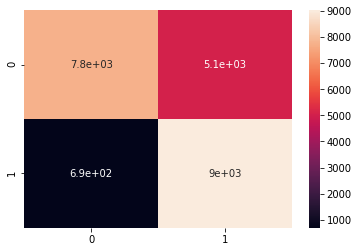

In [16]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_labels, prediction_scores)
import seaborn as sns
sns.heatmap(cm, annot=True)

In [17]:
cm

array([[7779, 5054],
       [ 692, 9018]])